In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv("h1b_cleaned_encoded.csv")

C:\Users\thakk\AppData\Local\Temp\ipykernel_14080\4239751877.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("h1b_cleaned_encoded.csv")


In [4]:
df = df.drop(columns=['COUNTRY_OF_CITIZENSHIP'])

In [5]:
def clean_naics(row):

    naics = str(row['NAICS_CODE'])
    new_naics = []
    for char in naics:
        if char == '-':
            pass
        else:
            new_naics.append(char)
    return ''.join(new_naics)



In [6]:
df['NAICS_CODE'] = df.apply(clean_naics,axis=1)

In [7]:
X = df.drop('target', axis=1)
y = df['target']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

In [9]:
from imblearn.ensemble import BalancedRandomForestClassifier


In [10]:
bal_rf_classifier = BalancedRandomForestClassifier(max_depth=40,n_estimators=100, random_state=101)

In [11]:
bal_rf_classifier.fit(X_train,y_train)

c:\Users\thakk\anaconda3\envs\usutf\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\thakk\anaconda3\envs\usutf\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\thakk\anaconda3\envs\usutf\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future 

BalancedRandomForestClassifier(max_depth=40, random_state=101)

In [12]:
predictions = bal_rf_classifier.predict(X_test)

In [13]:
cl_report = classification_report(y_test,predictions)

In [14]:
print(cl_report)

              precision    recall  f1-score   support

           0       0.06      0.75      0.11       618
           1       0.99      0.72      0.83     26492

    accuracy                           0.72     27110
   macro avg       0.52      0.73      0.47     27110
weighted avg       0.97      0.72      0.81     27110



### We can see that recall for minority i.e. H1B Denied has improved a lot by using BalancedRandomForestClassifier. However, this classifier does not accurately predicts this class (low precision), let's try using only important features

In [16]:
feature_importance = pd.DataFrame({"Feature":X.columns,"Importance":bal_rf_classifier.feature_importances_}).sort_values("Importance",ascending=False)

<Axes: xlabel='Importance', ylabel='Feature'>

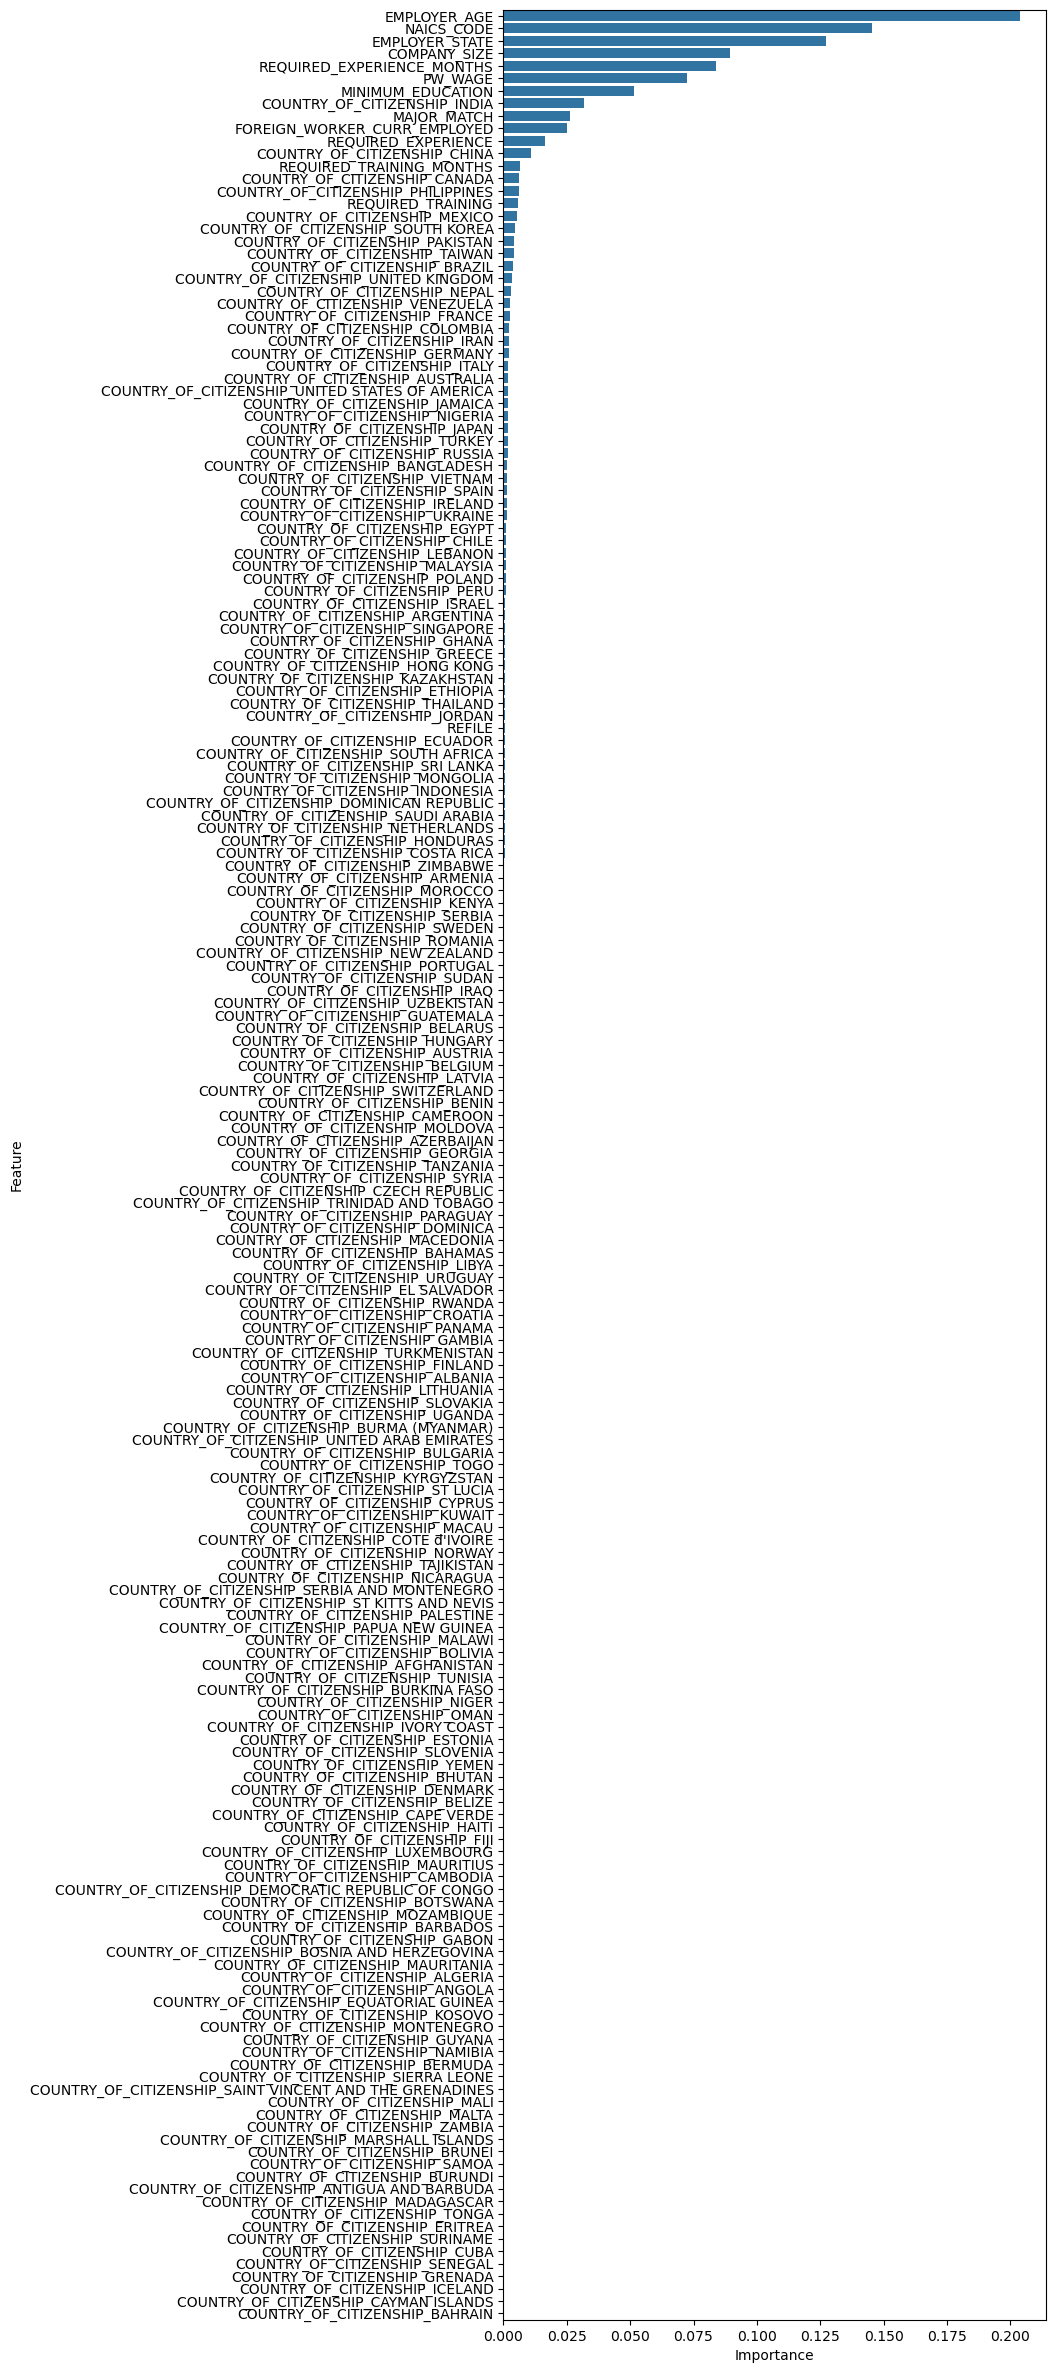

In [17]:
plt.figure(figsize=(7, 30))
sns.barplot(x='Importance',y='Feature',data=feature_importance)

In [18]:
important_features = feature_importance[feature_importance['Importance']>0.025].Feature.values
X_imp = df[important_features]
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y, test_size=0.3,random_state=101)


In [19]:
bal_rf_classifier2 = BalancedRandomForestClassifier(max_depth=40,n_estimators=100, random_state=101)

In [20]:
bal_rf_classifier2.fit(X_train_imp,y_train_imp)

c:\Users\thakk\anaconda3\envs\usutf\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\thakk\anaconda3\envs\usutf\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\thakk\anaconda3\envs\usutf\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future 

BalancedRandomForestClassifier(max_depth=40, random_state=101)

In [21]:
predictions2 = bal_rf_classifier2.predict(X_test_imp)

In [22]:
cl_report2 = classification_report(y_test_imp,predictions2)

In [23]:
print(cl_report2)

              precision    recall  f1-score   support

           0       0.06      0.75      0.11       618
           1       0.99      0.71      0.83     26492

    accuracy                           0.71     27110
   macro avg       0.52      0.73      0.47     27110
weighted avg       0.97      0.71      0.81     27110



### It can be seen that even after training a balanced random forest classifier on only important features, there are no improvements in minority class precision. The results for minority class are still the same.